In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import dtreeviz
from sklearn.metrics import mean_absolute_error


In [2]:
comp = 'titanic'
path = URLs.path(comp)
path

Path('/root/.fastai/archive/titanic')

In [3]:
creds = '{"username":"mathieuu","key":"REMOVED"}'

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

100%|██████████| 34.1k/34.1k [00:00<00:00, 12.9MB/s]

(#3) [Path('test.csv'),Path('gender_submission.csv'),Path('train.csv')]

In [6]:
def add_title(df):
    # Extracting the part after the comma and before the dot
    df['Title'] = df['Name'].str.extract(',(.*?)\.', expand=False)

    # Stripping off any leading or trailing whitespaces
    df['Title'] = df['Title'].str.strip()
    
def add_computed_columns(df):
    add_title(df)
    df['Cabin_present'] = ~df['Cabin'].isnull()

In [7]:
df = pd.read_csv(path/'train.csv', low_memory=False)
add_computed_columns(df)

df_test = pd.read_csv(path/'test.csv', low_memory=False)
add_computed_columns(df_test)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_present
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,False


In [8]:
modes = df.mode().iloc[0]

In [9]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))

## Random forest

In [10]:
cont = ['Age', 'SibSp', 'Parch', 'Fare']
cat = ['Sex', 'Embarked', 'Pclass', 'Cabin_present']
dep_var = 'Survived'

def mae(m, xs, y): return mean_absolute_error(m.predict(xs), y)

procs = [Categorify, FillMissing]

to_rf = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

xs_rf,y_rf = to_rf.train.xs,to_rf.train.y
valid_xs_rf,valid_y_rf = to_rf.valid.xs,to_rf.valid.y

def rf(xs, y, n_estimators=3, max_samples=713,
       max_features=0.5, min_samples_leaf=2, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

rfm = rf(xs_rf, y_rf, n_estimators=200, max_samples=0.4, max_features=0.7, min_samples_leaf=6)
print(mae(rfm, xs_rf, y_rf), mae(rfm, valid_xs_rf, valid_y_rf))

0.14866760168302945 0.19662921348314608


In [11]:
feature_importances = pd.DataFrame(rfm.feature_importances_,
                                   index = to_rf.train.xs.columns,
                                   columns=['importance']).sort_values('importance', 
                                                                       ascending=False)
print(feature_importances)

               importance
Sex              0.464784
Fare             0.180450
Pclass           0.126980
Age              0.119632
Cabin_present    0.037826
Embarked         0.028481
SibSp            0.019770
Parch            0.015664
Age_na           0.006412


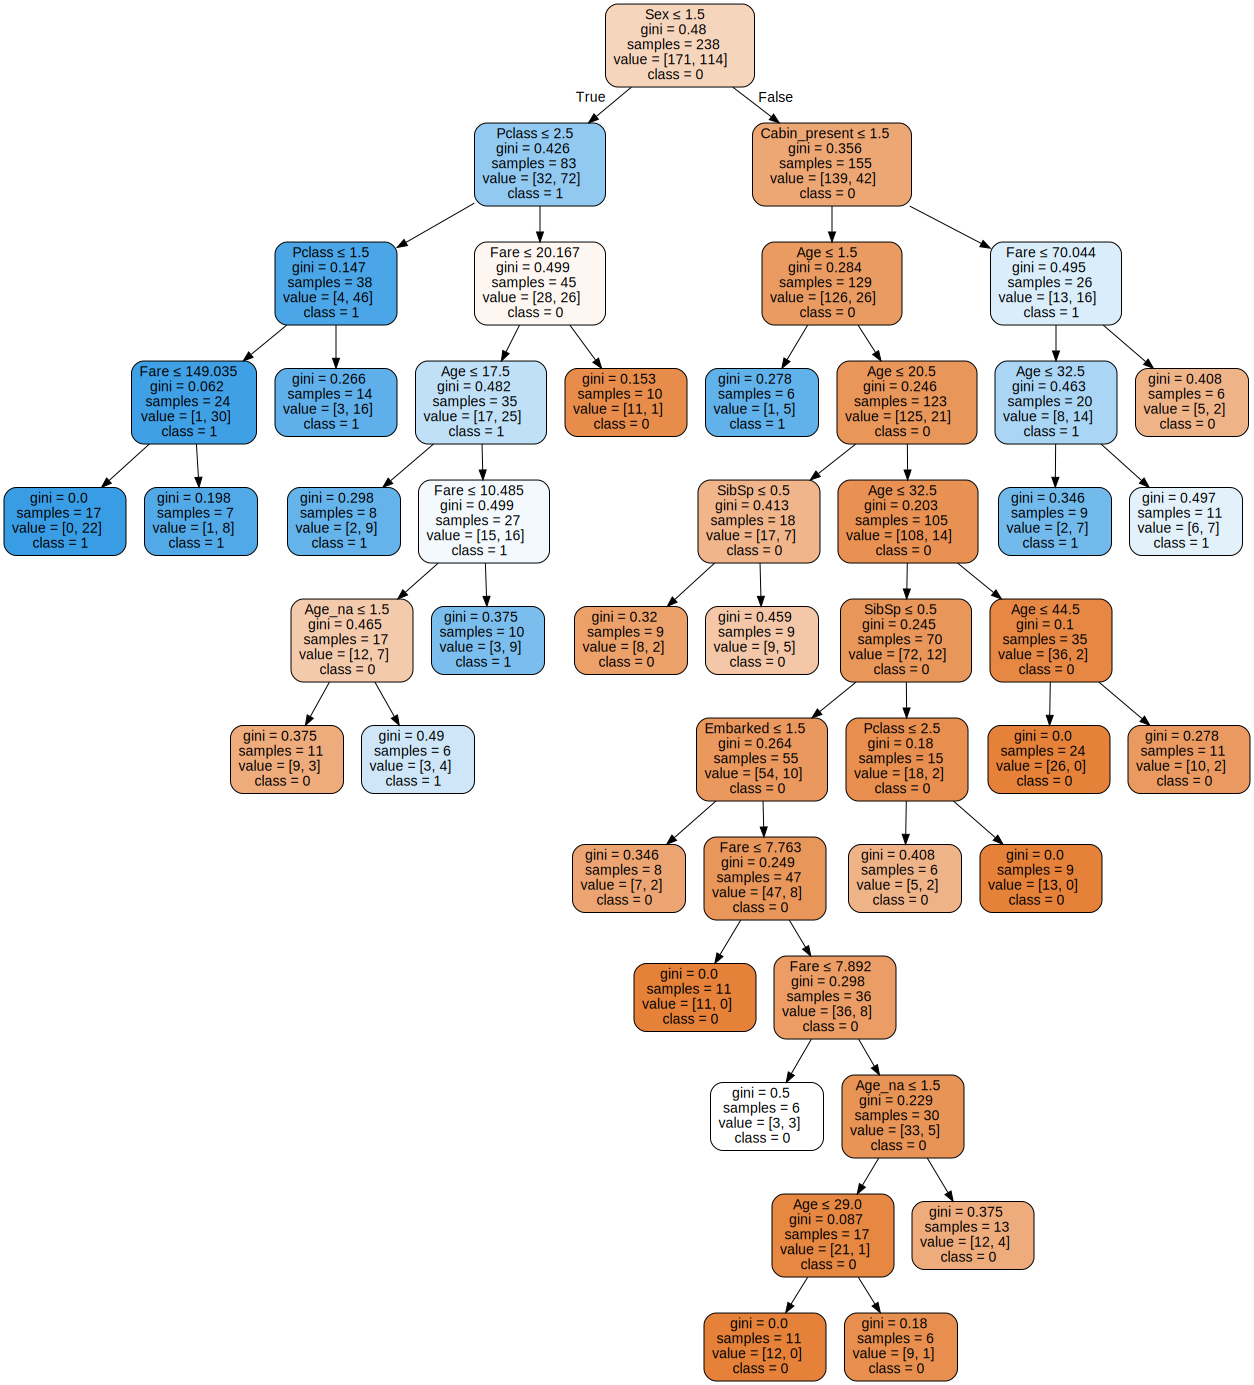

In [12]:
import graphviz  
from sklearn.tree import export_graphviz  
dot_data= export_graphviz(rfm.estimators_[10], out_file = None, 
                    feature_names = to_rf.train.xs.columns,  
                      class_names = ['0', '1'],  
                      filled = True, rounded = True,  
                      special_characters = True, impurity = True)  
graph = graphviz.Source(dot_data, format='png')  
graph

## Neural network

In [13]:
cont_nn = ['Age', 'SibSp', 'Parch', 'Fare']
cat_nn = ['Sex', 'Embarked', 'Pclass', 'Title']
dep_var_nn = 'Survived'

procs_nn = [Categorify, FillMissing, Normalize]

to_nn = TabularPandas(df, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var_nn, y_block=CategoryBlock)

dls_nn = to_nn.dataloaders(64)
dls_nn.show_batch()

,Sex,Embarked,Pclass,Title,Age_na,Age,SibSp,Parch,Fare,Survived
0,female,Q,3,Miss,False,15.000000,1.689237e-09,-9.897945e-09,8.029200,1
1,male,S,3,Mr,False,43.999999,1.689237e-09,-9.897945e-09,8.049999,0
2,male,S,1,Mr,False,61.000001,1.689237e-09,-9.897945e-09,33.500000,0
3,male,S,3,Mr,True,28.000000,8.000000e+00,2.000000e+00,69.550003,0
4,male,S,3,Mr,False,27.000000,1.689237e-09,-9.897945e-09,7.895800,0
5,male,S,1,Mr,False,51.000000,1.689237e-09,-9.897945e-09,26.549999,1
6,female,S,2,Miss,False,34.000000,1.689237e-09,-9.897945e-09,13.000001,1
7,male,S,3,Mr,False,20.000000,1.689237e-09,-9.897945e-09,9.845801,0
8,male,S,1,Capt,False,69.999999,1.000000e+00,1.000000e+00,71.000001,0
9,female,Q,3,Mrs,False,32.000000,1.000000e+00,1.000000e+00,15.500000,0


In [14]:
nnm = tabular_learner(dls_nn, layers=[50,20], metrics=accuracy)
nnm.fit_one_cycle(10, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.605283,0.607547,0.646067,00:00
1,0.522831,0.581417,0.837079,00:00
2,0.493881,0.462109,0.820225,00:00
3,0.471022,0.410284,0.848315,00:00
4,0.452865,0.403129,0.842697,00:00
5,0.437205,0.412198,0.853933,00:00
6,0.427908,0.396892,0.842697,00:00
7,0.417000,0.383978,0.853933,00:00
8,0.409971,0.379666,0.853933,00:00
9,0.403905,0.379411,0.853933,00:00


## Ensemble

In [15]:
def esm(preds_nn, preds_rf):
    ensemble_proba = (preds_nn[:, 1] + preds_rf[:,1]) / 2.0
    return [1 if prob > 0.5 else 0 for prob in ensemble_proba]

Test validation

In [16]:
valid_to_rf = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
valid_xs_rf,valid_y_rf = valid_to_rf.valid.xs,valid_to_rf.valid.y

valid_to_nn = TabularPandas(df, procs_nn, cat_nn, cont_nn, y_names=dep_var_nn, y_block=CategoryBlock, splits=splits)
valid_dls_nn = valid_to_nn.dataloaders(64)

from sklearn.metrics import accuracy_score
valid_preds_rf = torch.tensor(rfm.predict_proba(valid_xs_rf))
valid_y_rf = torch.tensor(valid_y_rf.to_numpy())
valid_accuracy_rm = accuracy(valid_preds_rf, valid_y_rf)
print(f'Accuracy of random forest: {valid_accuracy_rm}')

valid_preds_nn, _ = nnm.get_preds(dl=valid_dls_nn[1])
valid_y_nn = torch.tensor(valid_dls_nn[1].train['Survived'].to_numpy())
valid_accuracy_nn = accuracy(valid_preds_nn, valid_y_nn)
print(f'Accuracy of neural network: {valid_accuracy_nn}')

valid_predictions_esm = esm(valid_preds_nn, valid_preds_rf)
valid_accuracy_esm = accuracy_score(valid_y_nn, valid_predictions_esm)
print(f'Accuracy of ensemble model: {valid_accuracy_esm}')

Accuracy of random forest: 0.8033707737922668


Accuracy of neural network: 0.8539325594902039
Accuracy of ensemble model: 0.8595505617977528


In [17]:
nnm.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(4, 3)
    (2): Embedding(4, 3)
    (3): Embedding(18, 8)
    (4): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=24, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=50, out_features=20, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=20, out_features=2, bias=True)
    )
  )
)

In [18]:
nnm.loss_func

FlattenedLoss of CrossEntropyLoss()

Predict test dataset

In [19]:
df_test['Fare'].fillna(modes['Fare'], inplace=True)

In [20]:
test_to_rf = TabularPandas(df_test, procs, cat, cont)
test_xs_rf = test_to_rf.train.xs
test_preds_rf = torch.tensor(rfm.predict_proba(test_xs_rf))

test_dl_nn = dls_nn.test_dl(df_test)
test_preds_nn, _ = nnm.get_preds(dl=test_dl_nn)

test_predictions_esm = esm(test_preds_nn, test_preds_rf)

In [21]:
def subm(preds, suff):
    df_test['Survived'] = preds
    sub_df = df_test[['PassengerId','Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)
    

In [22]:
subm(test_predictions_esm, 'ensemble-titanic-3-with-title')

In [23]:
pd.set_option('display.max_rows', None)